# Etude de l'impact de la crise sanitaire sur le nombre d'établissments en Grand Est sur chaque secteurs d'activité 

In [1]:
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”


In [9]:
#------------------------------------------------------
# data pre treatment (similar tounivariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")
df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2 

In [11]:
df.ts %>%head
cat("dim : ",dim(df.ts))

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,889 Autre action sociale sans hébergement,931 Activités liées au sport,932 Activités récréatives et de loisirs,FZ_Construction,"GZ_Commerce, réparation d'automobiles et de motocycles",HZ_Transports et entreposage,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
2010 Q1,1290,355,70,156,1183,94,135,123,898,573,1435,1431,209,45,306,17,261,109,18,32,211,67,338,978,3087,49
2010 Q2,1284,354,72,156,1192,92,136,124,897,570,1451,1445,213,42,302,17,263,112,19,30,212,69,341,1019,3154,50
2010 Q3,1279,356,72,156,1147,92,148,126,902,572,1462,1382,228,42,319,17,299,109,19,32,205,71,346,996,3119,54
2010 Q4,1278,347,72,156,1185,94,139,125,905,573,1435,1459,212,42,315,17,252,112,19,32,199,71,345,1023,3133,51
2011 Q1,1276,393,71,155,1168,99,150,124,902,565,1437,1438,209,43,307,17,254,111,20,29,198,71,341,1002,3056,49
2011 Q2,1274,394,71,153,1179,98,151,125,908,561,1439,1410,208,41,303,17,255,110,17,29,204,69,346,1035,3107,47


dim :  40 26

En multivarié on est en présence d'un processus de 26 dimensions de longueur $T=40$

In [19]:
#dimnames(df.ts)[2]
colnames(df.ts)

[1] "64 Activités des services financiers, hors assurance et"
 [2] "65-66 Assurance ; Activités auxiliaires de services fin"
 [3] "852 Enseignement primaire"                              
 [4] "853 Enseignement secondaire"                            
 [5] "85x Enseignement / Autre"                               
 [6] "861 Activités hospitalières"                            
 [7] "862 Activité des médecins et des dentistes"             
 [8] "869 Autres activités pour la santé humaine"             
 [9] "87 Hébergement médico-social et social"                 
[10] "881 Action sociale sans hébergement pour personnes âgée"
[11] "889 Autre action sociale sans hébergement"              
[12] "931 Activités liées au sport"                           
[13] "932 Activités récréatives et de loisirs"                
[14] "FZ_Construction"                                        
[15] "GZ_Commerce, réparation d'automobiles et de motocycles" 
[16] "HZ_Transports et entreposage"                           
[17] "IZ_Hébergement et restauration"                         
[18] "JA_Edition et audiovisuel"                              
[19] "JB-JC_Télécommunications et ativités informatiques"     
[20] "LZ_Activités immobilières"                              
[21] "MA_Activités juridiques, de conseil et d'ingénierie"    
[22] "MB-MC_R&d et autres activités scientifiques et techniqu"
[23] "NZ_Activités de services administratifs et de soutien"  
[24] "RZ_Arts, spectacles et activités récréatives"           
[25] "SZ_autres activités de services"                        
[26] "i_Industrie et agriculture"

**Dans un premier temps nous allons continuer notre démarche naîvement , en ne prenant pas compte le problème de dimension induit par un processus de 27 dimensions**

<hr>

## I. Statistiques descriptives de notre processus

In [20]:
mean(df.ts[,1])

[1] 1199.7

In [31]:
ts.means  <- apply(df.ts,2,mean)%>% as.data.frame()
names(ts.means) <- "mean"
ts.means


,mean
,<dbl>
"64 Activités des services financiers, hors assurance et",1199.700
65-66 Assurance ; Activités auxiliaires de services fin,387.325
852 Enseignement primaire,68.950
853 Enseignement secondaire,147.925
85x Enseignement / Autre,1145.850
861 Activités hospitalières,97.875
862 Activité des médecins et des dentistes,159.850
869 Autres activités pour la santé humaine,131.475
87 Hébergement médico-social et social,939.675


In [33]:
apply(df.ts,2,summary)

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,⋯,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
Min.,1063.00,347.000,66.00,144.000,1055.00,92.000,135.00,123.000,897.000,547.000,⋯,210.000,103.000,12.00,24.00,188.00,58.00,278.0,978.00,2870.00,47.00
1st Qu.,1147.25,381.000,68.00,145.000,1119.00,96.750,152.00,126.750,919.000,551.000,⋯,218.000,109.000,15.75,28.00,196.50,61.00,309.5,1000.75,3052.25,53.00
Median,1214.50,390.000,69.00,146.500,1161.50,98.000,158.50,132.500,942.000,552.000,⋯,230.500,111.500,17.00,30.50,198.50,65.00,325.0,1025.00,3104.00,55.00
Mean,1199.70,387.325,68.95,147.925,1145.85,97.875,159.85,131.475,939.675,554.475,⋯,235.825,111.375,16.75,30.35,198.55,65.35,319.6,1024.20,3072.20,55.85
3rd Qu.,1257.50,394.250,70.00,148.250,1179.75,99.000,173.00,135.250,955.250,555.000,⋯,247.500,113.000,18.25,32.00,202.00,69.00,335.0,1040.25,3134.75,58.00
Max.,1318.00,418.000,73.00,157.000,1206.00,101.000,181.00,141.000,986.000,573.000,⋯,299.000,121.000,20.00,35.00,212.00,75.00,350.0,1081.00,3168.00,69.00


 L'on va rename les label de chaque secteurs d'activité afin de garder les prochains graphes lisibles

In [41]:
colnames(df.ts) %>%length

[1] 26

In [46]:
print("CORRESPONDANCE LABEL - NOMBRE SECTEURS")
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
lab.to.num

[1] "CORRESPONDANCE LABEL - NOMBRE SECTEURS"


lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


In [48]:
colnames(df.ts) <-lab.to.num$num

lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


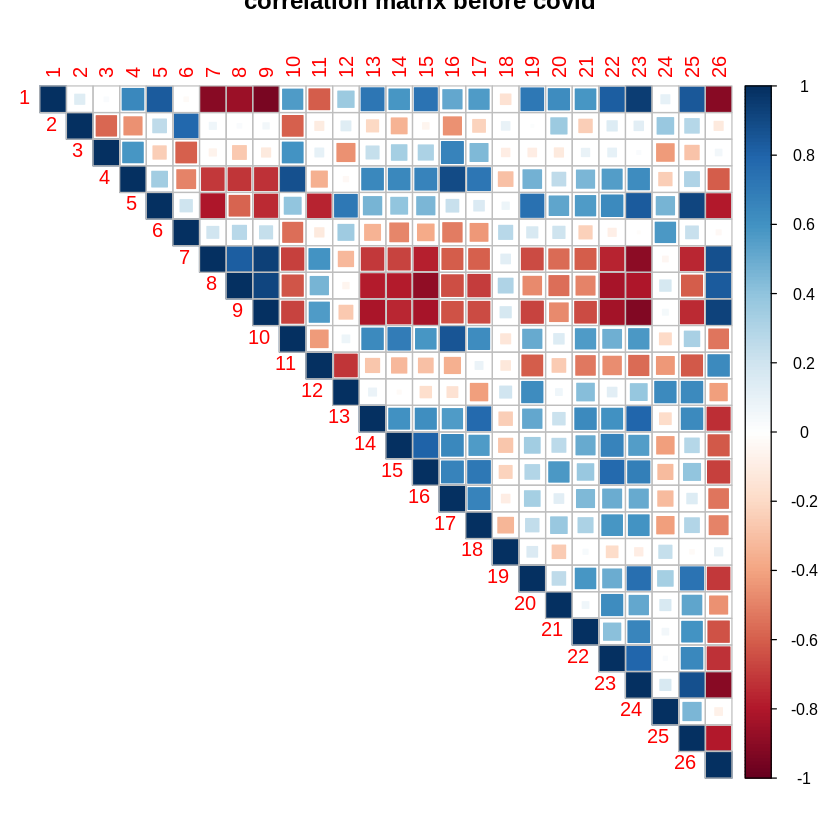

In [60]:
require(corrplot)
mcor <- cor(df.ts)
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")
lab.to.num

On peux voir qu'il y a des correlations plutot importantes entre nos différents secteurs d'activités.

Ceci montre qu'une analyse en multivarié à un interets. **En effets, étudier ces processus en multivariés permet de prendre en considerations les liens entre chaqun de ses processus afin de batir de meilleures prédiction qu'en univarié**

Regardons par la même occasion les statistiques lors de la période covid.

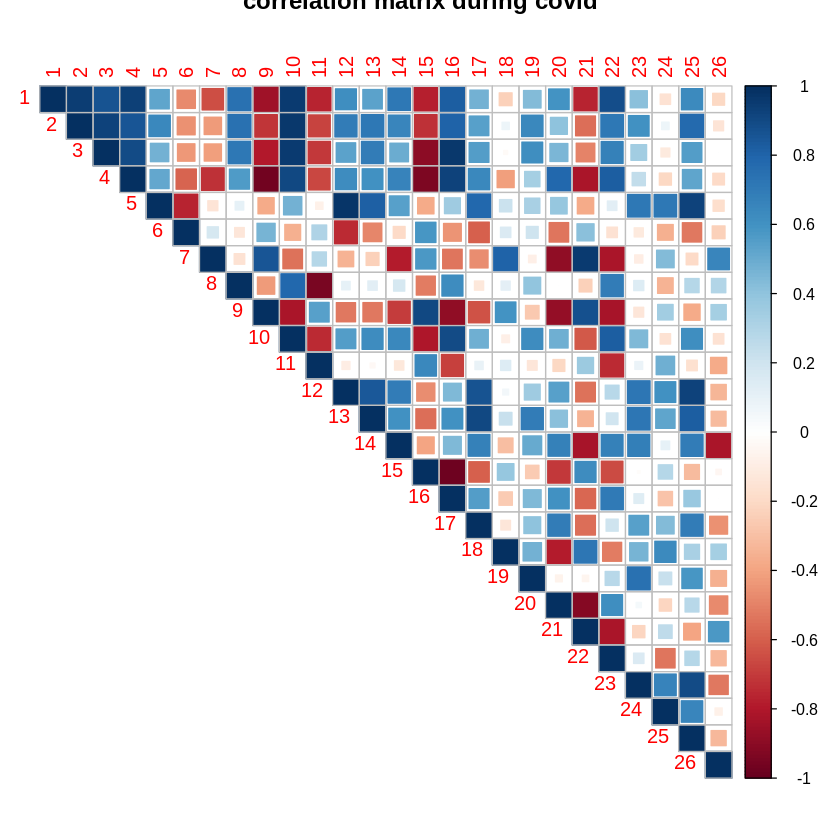

In [59]:
colnames(covid.ts) <- lab.to.num$num
mcor.covid <- cor(covid.ts)
corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")

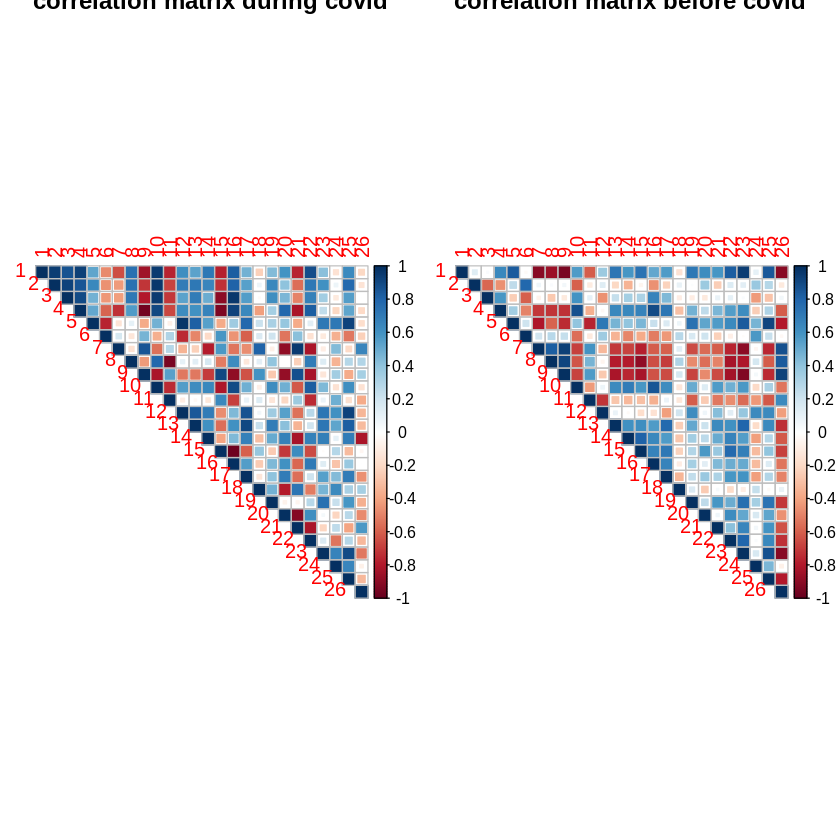

In [58]:
par(mfrow=c(1,2),mar=c(5,4,4,2))
corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")

 <hr>

## II.B. Multivariate TS Analysis

In [89]:
alpha <- 0.1
stationary.list <- list(
    "stable" = c(),
    "non-stable"=c()
)


for (index in 1: dim(df.ts)[2]){
    i <- df.ts[,index]
    p.val <- tseries::adf.test(i)$p.val
    if (p.val <=alpha){
        stationary.list[["stable"]]<- c(stationary.list[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list[["non-stable"]]<- c(stationary.list[["non-stable"]],colnames(df.ts)[index])    
    }
    
}



Warning message in tseries::adf.test(i):
“p-value smaller than printed p-value”
Warning message in tseries::adf.test(i):
“p-value smaller than printed p-value”
Warning message in tseries::adf.test(i):
“p-value greater than printed p-value”
Warning message in tseries::adf.test(i):
“p-value greater than printed p-value”
Warning message in tseries::adf.test(i):
“p-value greater than printed p-value”


In [90]:
stationary.list

$stable
[1] "2"  "10"

$`non-stable`
 [1] "1"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "11" "12" "13" "14" "15" "16" "17"
[16] "18" "19" "20" "21" "22" "23" "24" "25" "26"

**CCL :** Hormis 2 composants *(correspondant aux secteurs : "65-66 Assurance" et "881 Action sociales sans hébergement pour personnes agée )* , tous les composants représentent des TS non -stationnaire.

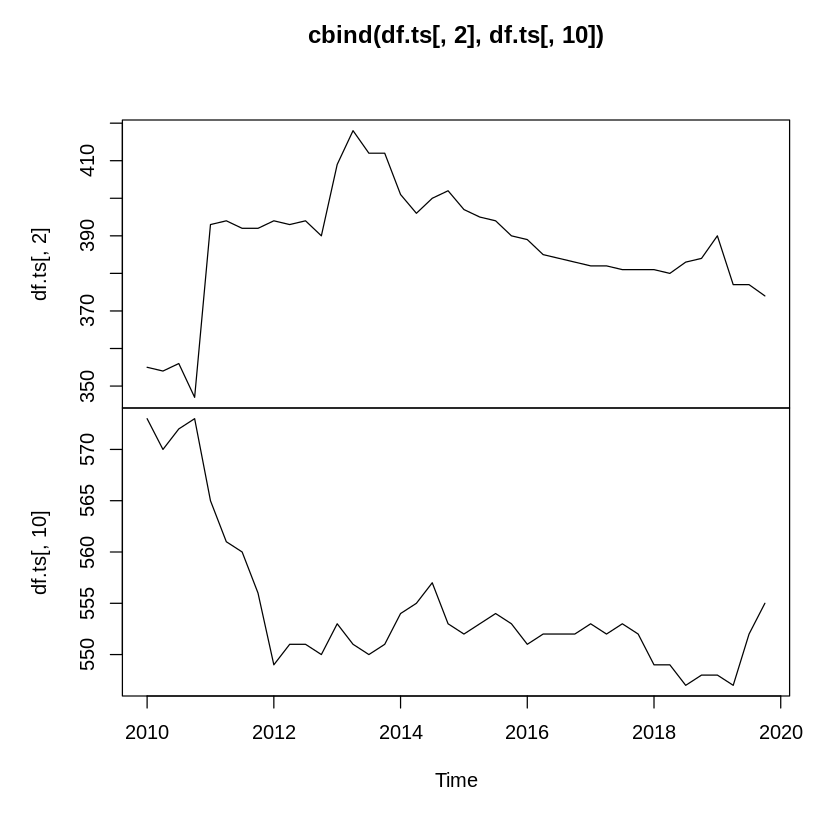

In [91]:
plot.ts(cbind(df.ts[,2],df.ts[,10]),plot.type = "multiple")

Elle ne semble pourtant pas etre très stationnaire , on sera amene à refaire des tests dessus

In [94]:
#---------------------------
# Refaire des tests plus complets sur ses 2 series

Utilisation de la differenciation du premeir ordre pour les compasants non stationnaire